In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

2024-10-27 18:52:09.109741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730065929.151958  141203 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730065929.166301  141203 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 18:52:09.315957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
import yfinance as yf
import datetime as dt
from datetime import date

# Load dataset
company = 'PETR4.SA'
end = date.today().strftime("%Y-%m-%d") # GRUPO : DECIDIR
start = '2020-01-01'  

data = yf.download(company, start=start, end=end)

print(data.head())


[*********************100%***********************]  1 of 1 completed

Price                      Adj Close      Close       High        Low  \
Ticker                      PETR4.SA   PETR4.SA   PETR4.SA   PETR4.SA   
Date                                                                    
2020-01-02 00:00:00+00:00  10.621441  30.700001  30.700001  30.309999   
2020-01-03 00:00:00+00:00  10.534945  30.450001  31.240000  30.450001   
2020-01-06 00:00:00+00:00  10.659497  30.809999  30.940001  29.950001   
2020-01-07 00:00:00+00:00  10.617980  30.690001  30.879999  30.469999   
2020-01-08 00:00:00+00:00  10.552242  30.500000  30.770000  30.240000   

Price                           Open    Volume  
Ticker                      PETR4.SA  PETR4.SA  
Date                                            
2020-01-02 00:00:00+00:00  30.510000  37774500  
2020-01-03 00:00:00+00:00  30.879999  71595600  
2020-01-06 00:00:00+00:00  30.430000  81844000  
2020-01-07 00:00:00+00:00  30.820000  32822000  
2020-01-08 00:00:00+00:00  30.690001  48215600  


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1202 entries, 2020-01-02 00:00:00+00:00 to 2024-10-25 00:00:00+00:00
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, PETR4.SA)  1202 non-null   float64
 1   (Close, PETR4.SA)      1202 non-null   float64
 2   (High, PETR4.SA)       1202 non-null   float64
 3   (Low, PETR4.SA)        1202 non-null   float64
 4   (Open, PETR4.SA)       1202 non-null   float64
 5   (Volume, PETR4.SA)     1202 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 65.7 KB


In [41]:
df = data["Close"]

In [42]:
df["Date"] = df.index

/tmp/ipykernel_141203/4039402861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = df.index


In [43]:
df = df.reset_index(drop=True)

In [44]:
df.head()

Ticker,PETR4.SA,Date
0,30.700001,2020-01-02 00:00:00+00:00
1,30.450001,2020-01-03 00:00:00+00:00
2,30.809999,2020-01-06 00:00:00+00:00
3,30.690001,2020-01-07 00:00:00+00:00
4,30.500000,2020-01-08 00:00:00+00:00


In [45]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler

# Normalize the Price column
scaler = MinMaxScaler()
df["PETR4.SA"] = scaler.fit_transform(df["PETR4.SA"].values.reshape(-1, 1))

In [46]:
df.head()

Ticker,PETR4.SA,Date
0,0.614046,2020-01-02 00:00:00+00:00
1,0.606137,2020-01-03 00:00:00+00:00
2,0.617526,2020-01-06 00:00:00+00:00
3,0.613730,2020-01-07 00:00:00+00:00
4,0.607719,2020-01-08 00:00:00+00:00


In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare the dataset
# n_steps is the number of previous days' prices to consider for prediction
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 10  # Number of time steps to consider for prediction

# Prepare the training data
data = df["PETR4.SA"].values
X, y = prepare_data(data, n_steps)

In [49]:
# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Reshape the input data for LSTM
X_train = X_train.reshape(-1, n_steps, 1)
X_test = X_test.reshape(-1, n_steps, 1)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2480
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0039
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015
Epoch 15/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012
Epoch 16/50
60/60

In [50]:
y_pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


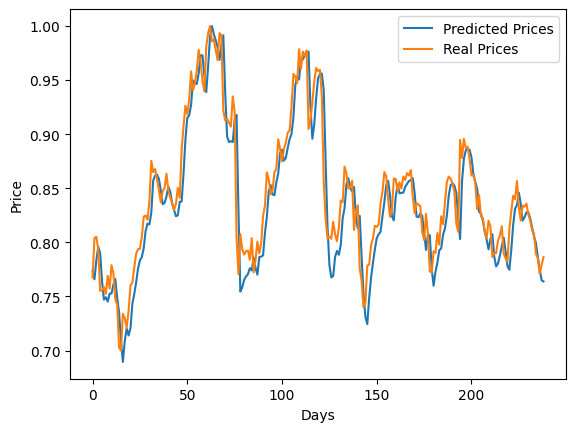

In [51]:
import matplotlib.pyplot as plt

# Plot the predicted prices
plt.plot(y_pred, label="Predicted Prices")
plt.plot(y_test, label="Real Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

In [52]:
# Predict using the trained model
future_steps = 10  # Number of days to predict
future_data = data[-n_steps:].reshape(-1, n_steps, 1)
predicted_prices = []

for i in range(future_steps):
    prediction = model.predict(future_data)[0, 0]
    predicted_prices.append(prediction)
    future_data = np.roll(future_data, -1, axis=1)
    future_data[0, -1] = prediction

# Inverse transform the predicted prices to original scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


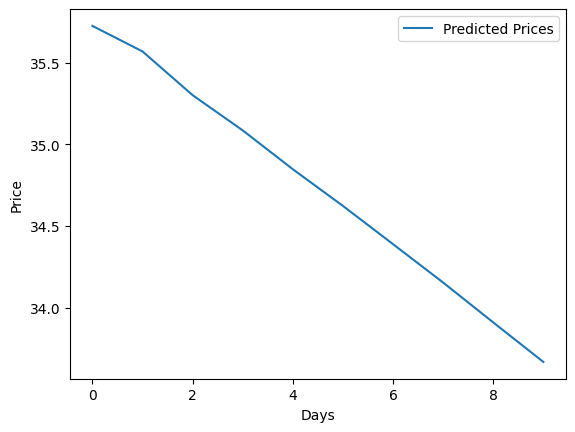

In [53]:
import matplotlib.pyplot as plt

# Plot the predicted prices
plt.plot(predicted_prices, label="Predicted Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()